In [ ]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from rdkit.Chem import PandasTools
from rdkit import Chem
from rdkit.Chem.MolStandardize import rdMolStandardize
from rdkit.Chem.rdmolops import FindPotentialStereo
# Alter here only

# Cria a variável que contem a lista de arqquivos que voce quer olhar, se for só um deixa como string
path_to_files = "./duplicate_analysis" #"D:\\Projetos academicos\\Labmol\\Code\\Data\\My_data\\Clinical Data\\Bundled_Data\\results"
# To get from a directory                          
# troca os.listdir por um método semelhante que percorra o drive
files = [f"{path_to_files}/{file}" for file in os.listdir(path_to_files)]
print(files)
name = [f"{file.strip('.xlsx')}" for file in os.listdir(path_to_files)]
name = [f"{n.strip('.csv')}" for n in name]
your_smiles = "Chemical Structure"
your_values = "Dose"
your_study_type = "EC50"
result_name="Sparse_Clinical_Hepatotox"

Convert to csv 

In [ ]:
"""def pandas_convert_excel_to_csv(files : str or list):
    if type(files) is list:
        for file in files:
            if file.find(".xlsx")!=-1:
                sheets = pd.ExcelFile(file).sheet_names
                for sheet in sheets:
                    df = pd.read_excel(file,sheet_name=sheet)
                    df.to_csv(f"./temp_dataset/{file}_{sheet}.csv")
    else:
        if files.find(".xlsx")!=-1:
            sheets = pd.ExcelFile(files).sheet_names
            for sheet in sheets:
                df = pd.read_excel(files,sheet_name=sheet)
                df.to_csv(f"./temp_dataset/{files}_{sheet}.csv")
try:
    os.mkdir("./temp_dataset")
    pandas_convert_excel_to_csv(files)
    s_file = [f"{path_to_files}\\{file}" for file in os.listdir("./temp_dataset")]
except FileExistsError:
    pandas_convert_excel_to_csv(files)
    s_file = [f"{path_to_files}\\{file}" for file in os.listdir("./temp_dataset")]"""

In [ ]:

def organize(all_df_list):
    #smiles_list=[]
    #for df_name in all_df_list:
        
    #df_smiles=[]
    for i,df_name in enumerate(all_df_list):
        if df_name.find(".sheet")!=-1:
            file = df_name.split(".sheet")
            print(file)
            df = pd.read_excel(file[0],sheet_name=file[1])
        else:
            df = pd.read_csv(df_name)


        smiles = df.loc[:,your_smiles]
        d_f = df.dropna(axis=0, how='all')
        #df = pd.DataFrame([inchik,canon_smiles,df.loc[:,new_values]],columns=["Inchi","SMILES",new_values])
        canon_smiles = []
        inchik = []
        #smiles_s = df[smiles_col]
        for ds in smiles:
            try:
                cs = Chem.CanonSmiles(ds)
                mol = Chem.MolFromSmiles(cs)
                inchik.append(Chem.rdinchi.MolToInchiKey(mol))
                canon_smiles.append(cs)
            except:
                d_f.drop(index=i,drop=True,inplace=True)
                d_f.reset_index(drop=True, inplace=True)
        #print(len(inchik))
        new_values = f"{your_study_type}_{i}"              
        df = pd.DataFrame()
        df["Inchi"] = inchik
        df["SMILES"] = canon_smiles
        df[new_values] = d_f.loc[:,your_values]
        #df = df.drop(your_smiles, axis=1)
        
        #smiles_col = f"Smiles {i}"

        
        #df = df.rename(columns={your_values:new_values})#, your_smiles:smiles_col})
        
        #mols = []
        
        
        # if i > 1:
        #     #df_smiles.clear()
        # # df_all_inchi=pd.merge(df_all_inchi,df, how="outer",on="SMILES")
        #     df_all_inchi = pd.merge(df_all_inchi, df, how="outer", on=["Inchi","SMILES"])
        if i == 0:
            #df_smiles[i] = df
            df_all_inchi = df
        elif i >= 1: 
            #df_smiles[i] = df
            #prev_df = df_smiles[i-1]
            # df_all_inchi=pd.merge(df,prev_df, how="outer", on="SMILES")
            try:
                df_all_inchi = df_all_inchi.merge(df, how = "outer", on = ["Inchi","SMILES"],validate="one_to_one")
            except:
                merged_inchi = df_all_inchi["Inchi"]
                for inchi in df["Inchi"]:
                    if inchi in merged_inchi:
                        df.drop(index=inchi,inplace=True)

                df_all_inchi = df_all_inchi.merge(df, how = "outer", on = ["Inchi","SMILES"])
            
            df_all_inchi.drop_duplicates("Inchi",inplace=True)
            print(f"File {df_name}")
            print(f"Df size {df.shape[0]}")
            print(f"Df_inchi Size {df_all_inchi.shape[0]}")
    id_=[f"'{num}'" for num in range(df_all_inchi.shape[0])]    
    df_all_inchi.insert(0,"ID",id_)
    df_all = df_all_inchi.drop("Inchi", axis=1)
    
    return df_all
    

def read_through_files(files):
        dfs = []
        names = []
        if type(files) is str:
            # name=result_name
            # name=name.replace(".xlsx","")
            # name=name.replace(".csv","")
            if files.find(".csv") != -1:
                #names.append(name)
                dfs.append(f"{files}")#pd.read_csv(files,delimiter=","))
                #organize(df,name)
            else:
                sheets = pd.ExcelFile(files).sheet_names
                if len(sheets)>1:
                    for sheet in sheets:
                        if sheet != ".":
                            #names.append(sheet)
                            dfs.append(f"{files}.sheet{sheet}")#pd.read_excel(files,sheet_name=sheet))
                            #organize(df,name)
                else:
                    for sheet in sheets:
                        if sheet != ".":
                            #name.append(files)
                            dfs.append(f"{files}.sheet{sheet}")#pd.read_excel(files,sheet_name=sheet))
        else:
            for file in files:
                if file.find(".csv") != -1:
                   # names.append(files)
                    dfs.append(f"{file}")#pd.read_csv(file,delimiter=","))
                else:   
                    sheets = pd.ExcelFile(file).sheet_names
                    if len(sheets)>1:
                        for sheet in sheets:
                            if sheet != ".":
                                #names.append(sheet)
                                dfs.append(f"{file}.sheet{sheet}")#pd.read_excel(file,sheet_name=sheet))
                                #organize(df,name)
                    else:
                        for sheet in sheets:
                            if sheet != ".":
                                #name.append(file)
                                dfs.append(f"{file}.sheet{sheet}")#pd.read_excel(file,sheet_name=sheet))
        return organize(dfs)
df = read_through_files(files=files)
#df.fillna(np.nan,inplace=True)
df.head()

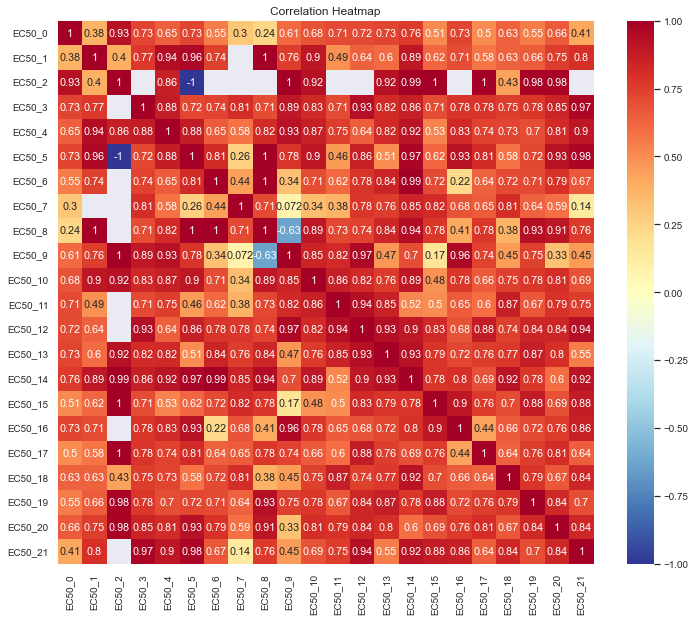

In [62]:
correlation_df = df
corr = correlation_df.corr()
sns.set_style('darkgrid')
sns.set(font_scale=0.9, rc={'figure.figsize':(12,10)})
sns.heatmap(corr, cmap='RdYlBu_r', vmin=-1, vmax=1, annot=True)
plt.title('Correlation Heatmap', fontsize=12)
plt.savefig('Correlation.png', bbox_inches='tight',
            transparent=True, format='png', dpi=400)

# convert back to id numbers
correlation_df["ID"] = [int(str_.strip("'")) for str_ in correlation_df["ID"]]
correlation_df.to_csv(f"./results/{result_name}.csv",index=False)
